In [2]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

# comp-linguistics
import spacy
import nltk
from spacy import displacy
#Using NLP in spanish
nlp = spacy.load("es_core_news_sm")

import os
from os import listdir
from os.path import isfile, join

from stop_words import get_stop_words
stop_words = get_stop_words('es')

In [3]:
def loadcorpus2(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        file2 = corpus_name + "/" + file
        print(file)
        texts_raw[file] = []
        with open(file2, encoding='utf-8') as f:
            for line in f:
                texts_raw[file].append(line)
    return texts_raw

In [4]:
speeches_dir = 'data/presidentialSpeechPeru/txt'
speeches_raw = loadcorpus2(speeches_dir)

mensaje-1992-af.txt
mensaje-2004-at.txt
mensaje-2006-ag.txt
mensaje-2019-01-vizcarra.txt
mensaje-2014-oh.txt
mensaje-2008-ag.txt
mensaje-1984-fbt.txt
mensaje-1990-af.txt
mensaje-2000-af.txt
mensaje-2002-at.txt
mensaje-1986-ag.txt
mensaje-1994-af.txt
mensaje-1998-af.txt
mensaje-1988-ag.txt
mensaje-1996-af.txt
mensaje-2010-ag.txt
mensaje-2012-oh.txt
mensaje-2007-ag.txt
mensaje-2005-at.txt
mensaje-2018-4.txt
mensaje-1993-af.txt
mensaje-1982-fbt.txt
mensaje-2017-ppk.txt
mensaje-1983-fbt.txt
mensaje-2016-ppk.txt
mensaje-1991-af.txt
mensaje-2009-ag.txt
mensaje-2015-oh.txt
mensaje-1995-af.txt
mensaje-1999-af.txt
mensaje-1987-ag.txt
mensaje-1981-fbt.txt
mensaje-2011-oh.txt
mensaje-2003-at.txt
mensaje-2001-at.txt
mensaje-2013-oh.txt
mensaje-1997-af.txt
mensaje-1989-ag.txt
mensaje-1985-ag.txt
mensaje-1980-fbt.txt


In [5]:
import re
speech = pandas.DataFrame()
filenames = []
raw = []
for filename, raw_speech in speeches_raw.items():
    filenames.append(filename)
    raw.append(raw_speech)
speech['filename'] = filenames
speech['raw text'] = raw

pattern = re.compile('[0-9]{4}')
speech['year'] = speech['filename'].apply(lambda x: pattern.search(x).group(0))
speech = speech.sort_values(by='year').reset_index(drop=True)

In [6]:
def clean_raw_text2(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            if type(text) == bytes:
                text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_text = clean_text.replace("\n", "").replace("\xa0", "").replace("\x0c", "")
            if not (clean_text == '' or clean_text == ' '):
                clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return ' '.join(clean_texts)

In [7]:
speech['cleaned text'] = speech['raw text'].apply(lambda x: clean_raw_text2(x))


In [8]:
speech.loc[(speech['year'].astype('int32') <= 1984), 'administration'] = 'Belaunde'

speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'administration'] = 'Garcia (1)'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 1994), 'administration'] = 'Fujimori(1)'

speech.loc[(speech['year'].astype('int32') >= 1995) & \
           (speech['year'].astype('int32') <= 2000), 'administration'] = 'Fujimori(2)'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'administration'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'administration'] = 'Garcia (2)'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'administration'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016), 'administration'] = 'Kuzcynski/Vizcarra'

speech.loc[(speech['year'].astype('int32') <= 1984), 'president'] = 'Belaunde'
speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 2000), 'president'] = 'Fujimori'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'president'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'president'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016) & \
           (speech['year'].astype('int32') <= 2017), 'president'] = 'Kuzcynski'

speech.loc[(speech['year'].astype('int32') >= 2018), 'president'] = 'Vizcarra'

speech['year-president'] = speech['year'] + '-' + speech['president']


In [9]:
speechTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(min_df=5, stop_words=stop_words, norm='l2')

In [10]:
targetDF = speech
textColumn = 'cleaned text'

In [11]:
speechTFVects = speechTFVectorizer.fit_transform(targetDF[textColumn])

In [12]:
terms = speechTFVectorizer.get_feature_names()

In [13]:
cat = [3,4,5,6,7]
for num in cat:
    numCategories = num
    speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
    speechKM.fit(speechTFVects)
    targetDF['kmeans' + str(numCategories)] = speechKM.labels_

In [14]:
speechPCA = sklearn.decomposition.PCA(n_components = 2).fit(speechTFVects.toarray())
reducedPCA_speechData = speechPCA.transform(speechTFVects.toarray())

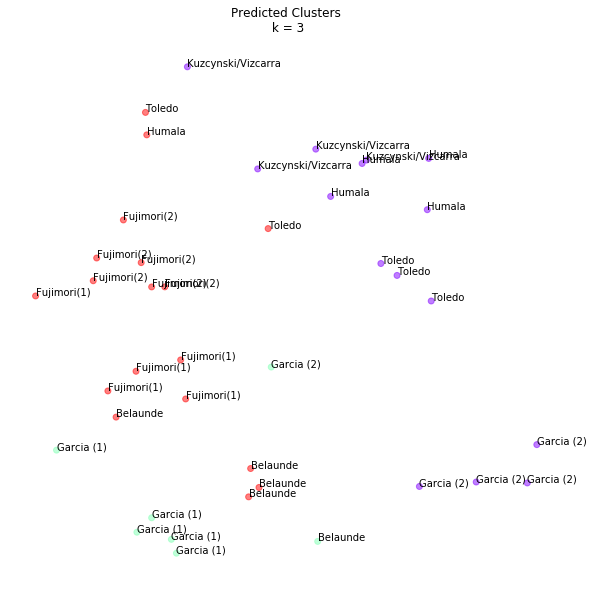

In [15]:
numCategories = 3
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
#for i, word in enumerate(words):
#    ax.annotate(word, (x[i],y[i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

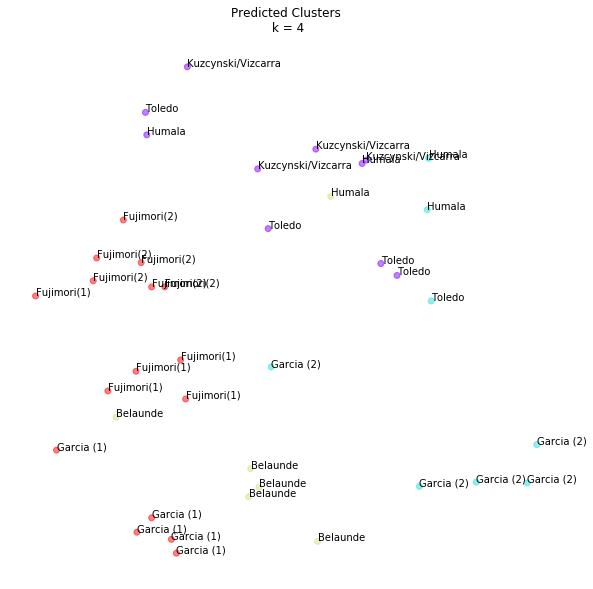

In [16]:
numCategories = 4
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

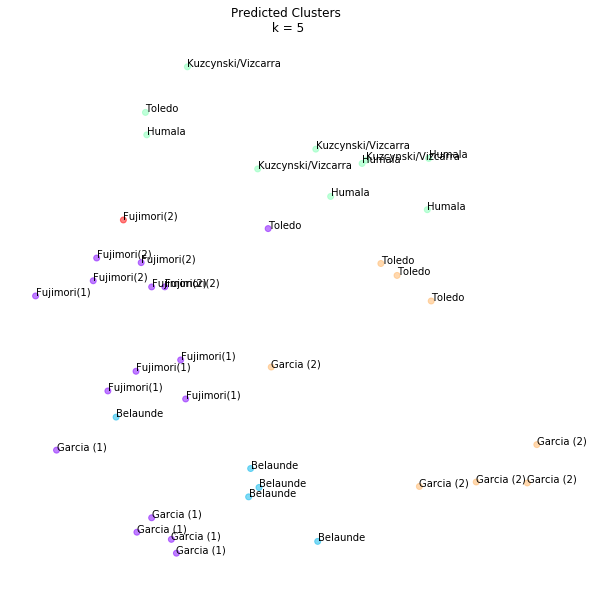

In [17]:
numCategories = 5
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

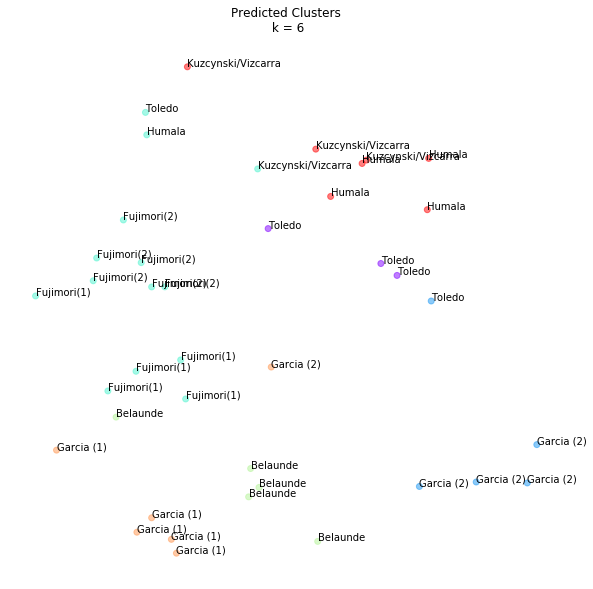

In [18]:
numCategories = 6
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

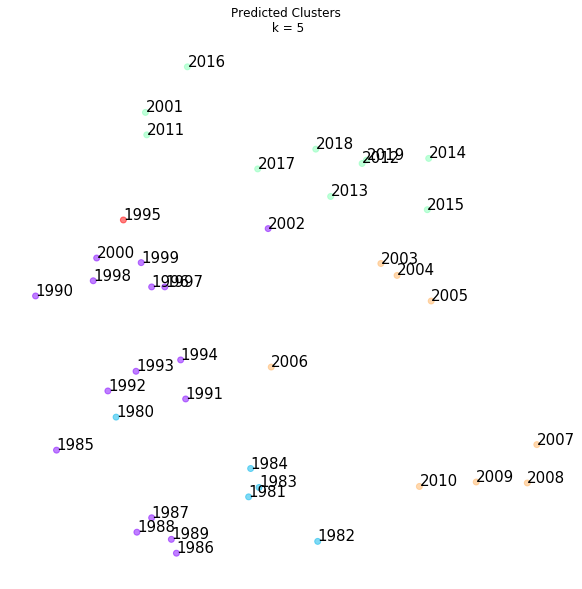

In [19]:
numCategories = 5
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

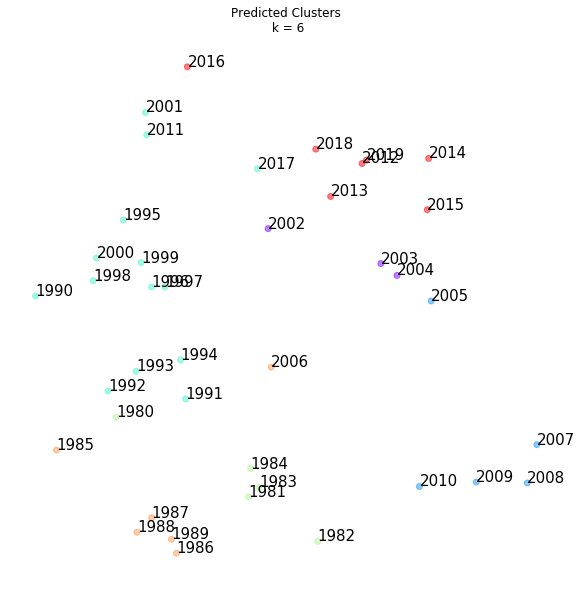

In [20]:
numCategories = 6
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

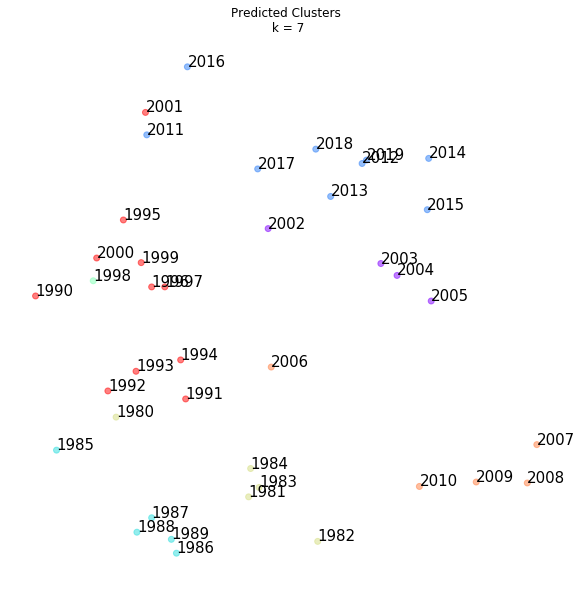

In [21]:
numCategories = 7
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In [22]:
terms = speechTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = speechKM.cluster_centers_.argsort()[:, ::-1]
for i in range(7):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 mil
 gobierno
 millones
 nacional
 año
 perú
 soles
 hoy
 ley
 congreso
 país
 2004
 dólares
 programa
 peruanos
 nuevos
 2001
 presidente
 años
 inversión


Cluster 1:
 país
 perú
 año
 mil
 gobierno
 millones
 nacional
 salud
 peruanos
 soles
 000
 años
 2016
 corrupción
 desarrollo
 hoy
 proyectos
 inversión
 sistema
 calidad


Cluster 2:
 perú
 gobierno
 000
 país
 nacional
 si
 sólo
 pueblo
 años
 debe
 ser
 millones
 social
 año
 democracia
 dólares
 puede
 meses
 ahora
 producción


Cluster 3:
 país
 perú
 economía
 gobierno
 si
 camisea
 plata
 pues
 decir
 alguien
 fujimori
 vacas
 reservas
 bien
 estabilidad
 hoy
 ser
 aquí
 simplemente
 tamaño


Cluster 4:
 nacional
 gobierno
 país
 perú
 año
 desarrollo
 000
 mil
 millones
 1982
 debe
 1983
 obras
 1981
 construcción
 1980
 plan
 sistema
 social
 obra


Cluster 5:
 mil
 millones
 perú
 año
 país
 años
 gobierno
 soles
 además
 obras
 kilómetros
 inversión
 pueblo
 ahora
 empleo
 nacional
 

In [23]:
def plotSilhouette2(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))
    return silhouette_avg

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


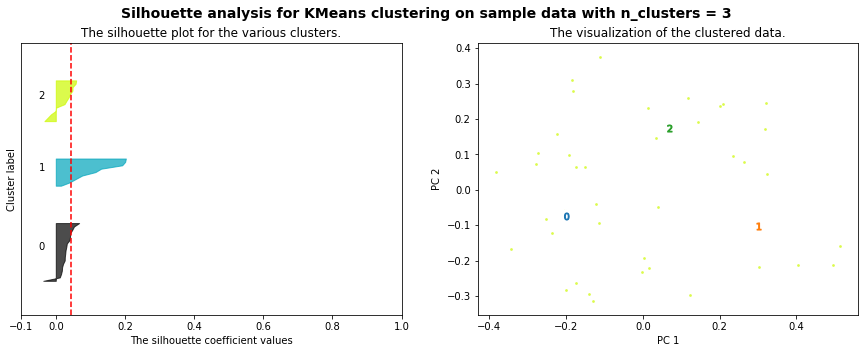

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


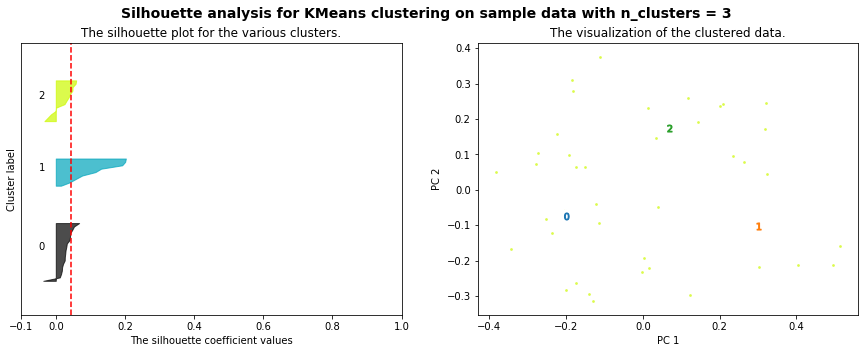

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


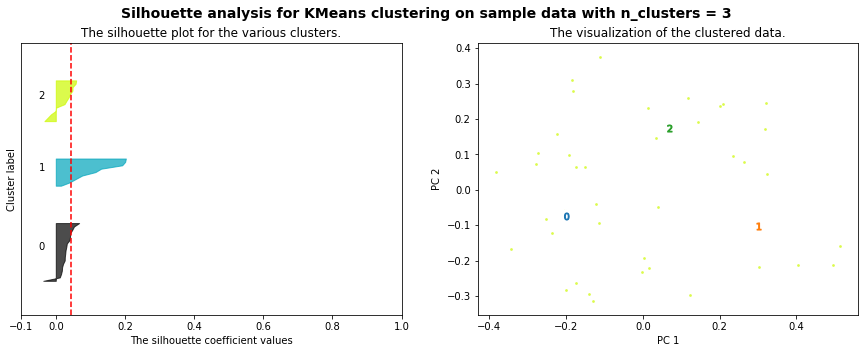

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


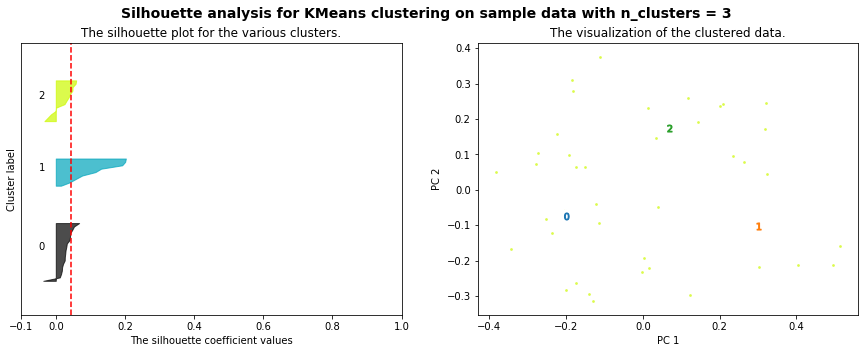

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


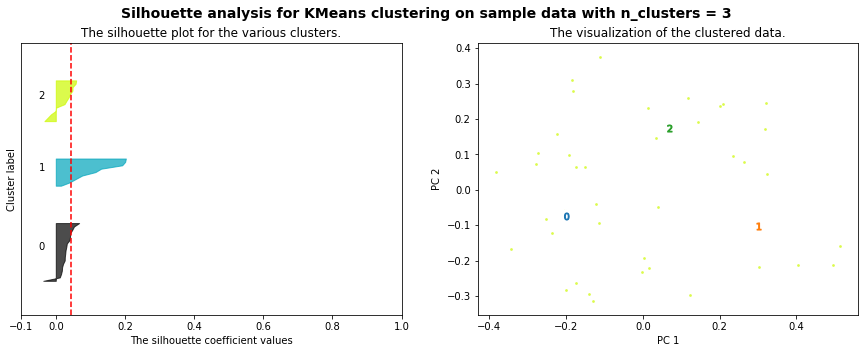

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


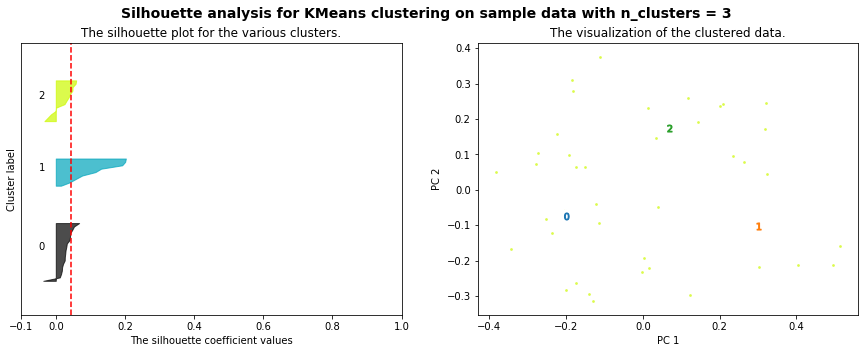

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


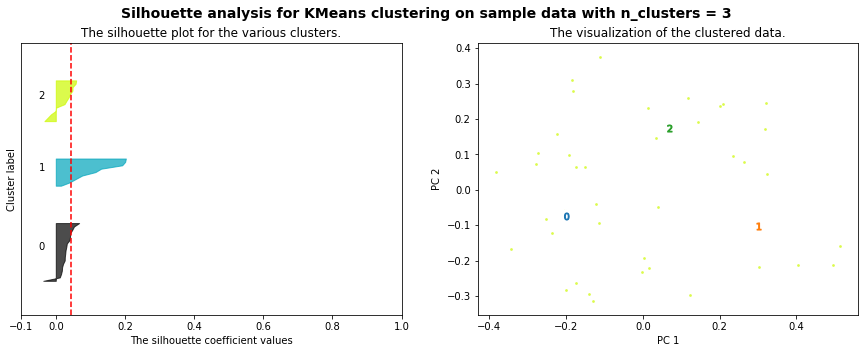

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.045


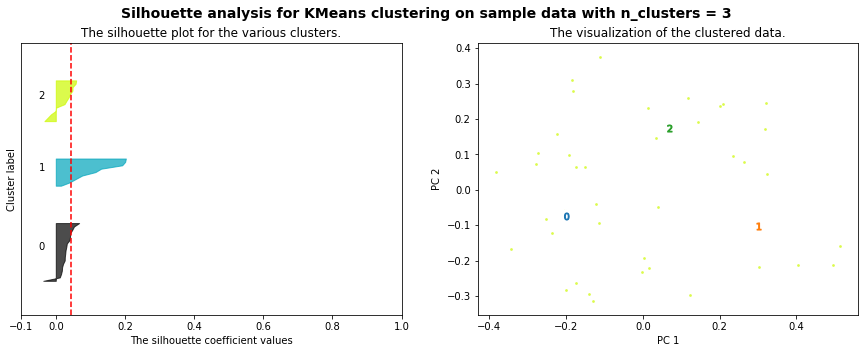

For n_clusters = 3, The average silhouette_score is : 0.045


In [24]:
X = speechTFVects.toarray()
max_sil = 0
n_clus=0
for c in [3,4,5,6,7,8,9,10]:
    sil = plotSilhouette2(3, X, reducedPCA_speechData, speechPCA)
    if sil > max_sil:
        max_sil = sil
        n_clus = c

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [25]:
speechCoocMat = speechTFVects * speechTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
speechCoocMat.setdiag(0)

In [26]:
linkage_matrix = scipy.cluster.hierarchy.ward(speechCoocMat.toarray())


/Users/csolisu/Library/Python/3.7/lib/python/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


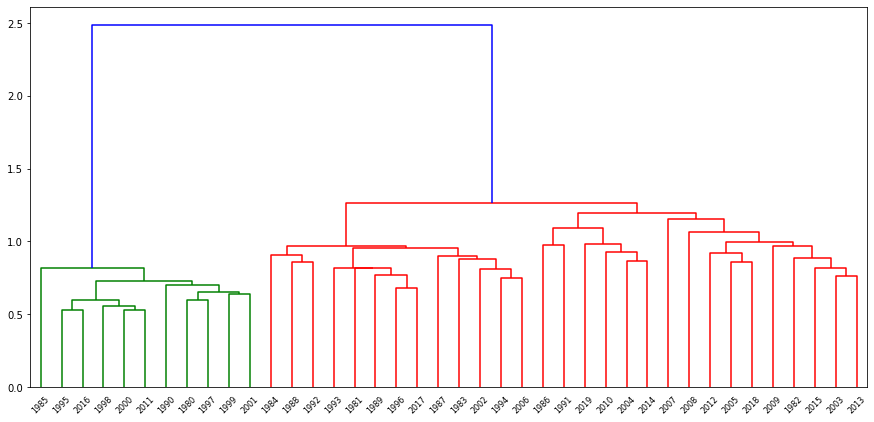

In [27]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True,labels=list(speech['year']))


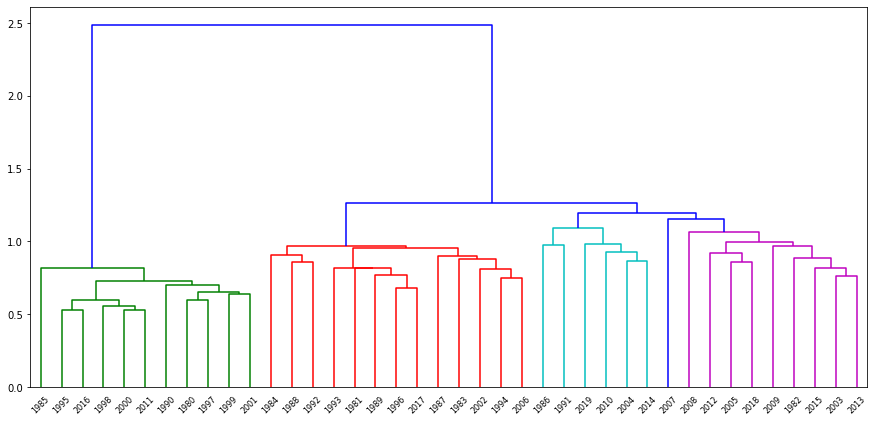

In [28]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.1)

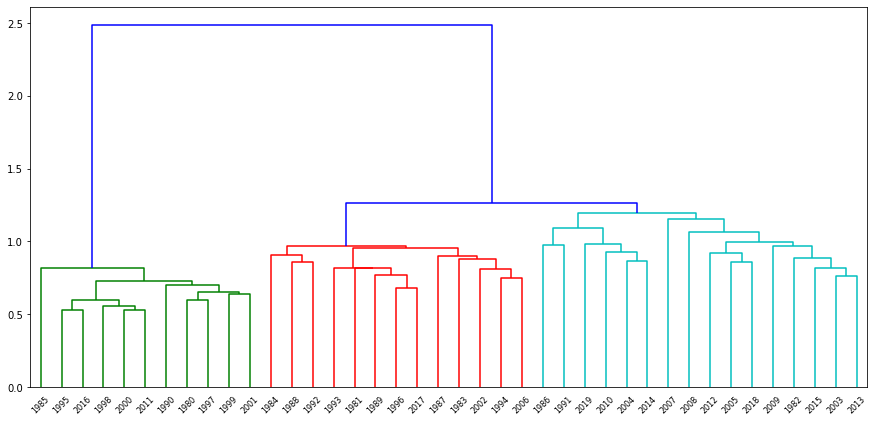

In [29]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.2)

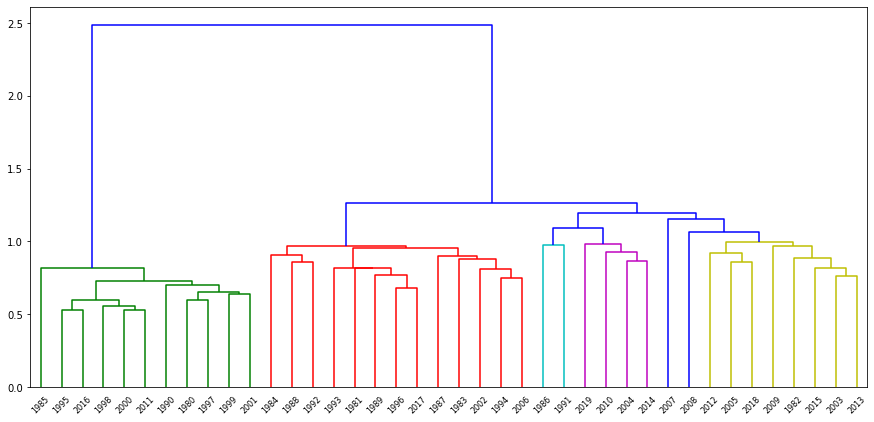

In [30]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),color_threshold=1.02)

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [31]:
speech['tokenized_text'] = speech['cleaned text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))


In [32]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [33]:
speech['normalized_tokens'] = speech['tokenized_text'].apply(lambda x: normalizeTokens(x))

In [34]:
speech['reduced_tokens'] = speech['normalized_tokens'].apply(lambda x: dropMissing(x, speechTFVectorizer.vocabulary_.keys()))

In [35]:
dictionary_speech = gensim.corpora.Dictionary(speech['reduced_tokens'])


In [36]:
corpus_speech = [dictionary_speech.doc2bow(text) for text in speech['reduced_tokens']]

In [37]:
gensim.corpora.MmCorpus.serialize('speech_peru.mm', corpus_speech)

In [38]:
n_topics = 7
speech_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_speech,
                                             id2word=dictionary_speech,
                                             num_topics=n_topics,
                                             alpha='auto',
                                             eta='auto'
                                            )

In [39]:
speech_ldaDF = pandas.DataFrame({
        'year' : speech['year'],
        'president': speech['president'],
        'year-president': speech['year-president'],
        'topics' : [speech_lda[dictionary_speech.doc2bow(l)] for l in speech['reduced_tokens']]
    })

In [40]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(speech_ldaDF) for i in range(speech_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(speech_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(speech_lda.num_topics):
    speech_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [41]:
speechDFV = speech_ldaDF[['topic_%d' %x for x in range(n_topics)]]
speechDFVisN = speech_ldaDF[['year-president']]
speechDFVis = speechDFV.as_matrix(columns=None)
speechDFVisNames = speechDFVisN.as_matrix(columns=None)
topic_labels = ['Topic #{}'.format(k) for k in range(n_topics)]

AttributeError: 'DataFrame' object has no attribute 'as_matrix'

numpy.float64

In [181]:
topicsDict = {}
for topicNum in range(speech_lda.num_topics):
    topicWords = [w for w, p in speech_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,país,año,país,año,millón,millón,año
1,año,país,año,país,perú,año,millón
2,millón,perú,perú,gobernar,año,país,país
3,perú,gobernar,nacional,millón,gobernar,gobernar,gobernar
4,peruano,millón,gobernar,perú,país,nacional,perú
5,gobernar,nacional,millón,nacional,nacional,peruano,nacional
6,social,peruano,peruano,peruano,político,perú,peruano
7,inversión,social,desarrollar,desarrollar,peruano,social,social
8,público,sector,público,político,social,político,inversión
9,político,político,social,empresa,desarrollar,deber,ley


In [182]:
plt.figure(figsize = (15,5))
plt.pcolor(speechDFVis.T, norm=None, cmap='Blues')
plt.xticks(np.arange(speechDFVis.shape[0])+0.5, speechDFVisNames);
plt.yticks(np.arange(speechDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

NameError: name 'speechDFVis' is not defined

<Figure size 1080x360 with 0 Axes>